In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-12-09 10:58:40.812348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 10:58:41.165503: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
ReadList = ["Mass", "evt_trig", "fourjetmasstev",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1high_dR", "P1low_dR",
        "P2high_dR", "P2low_dR",
        "P3high_dR", "P3low_dR",]

In [3]:
def add_more_cols(DF):
    DF["Truth"] = (DF["Mass"] > 0).astype(int)

In [4]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    if Mass == 0:
        TrainingRows = 100000*12
        TestingRows = 50000*12
        File = "ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root"
        
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    
    add_more_cols(DF)
    
    #TrainingRows = int(len(DF.index)*0.8)
    #TestingRows = int(len(DF.index)*0.2)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [5]:
Masses = [0, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

SanityCheckPlots = True

In [6]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_QCD_2M_stride30.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root





Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Memory used: 0.8158912658691406GB


In [7]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
0,0,1,2.211115,1.715419,0.120147,1.049766,0.287547,0.680098,0.549705,3.073240,0.943468,2.950556,1.046086,3.090627,1.368932,0
1,0,1,2.252633,1.421693,0.534707,1.005757,0.966361,0.892366,0.264961,2.545376,1.766797,2.281952,3.145134,1.561081,0.631176,0
2,0,1,2.000082,1.495827,0.342670,1.112898,0.512631,0.347012,0.251610,2.872335,2.073989,3.013735,2.460337,1.050098,0.528453,0
3,0,1,2.994123,2.548020,0.335539,1.100304,0.566532,0.841165,0.357062,3.584661,2.688623,3.227361,1.439887,2.147305,1.248952,0
4,0,1,2.170521,1.360183,0.167727,1.153168,0.456785,1.079114,0.384650,3.073375,0.569562,2.988158,1.205925,3.283349,0.875845,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,3000,1,5.470423,4.251276,0.237198,2.451948,0.464031,2.324757,0.526192,2.827187,0.431370,2.890104,0.445448,2.498758,0.519984,1
2399996,3000,1,5.158958,3.317512,1.569893,2.951189,1.684289,1.114346,0.661268,3.045882,2.520814,3.055783,2.555565,0.824982,0.667885,1
2399997,3000,1,6.064116,2.982766,2.600989,2.885411,1.632892,2.879766,1.394185,2.924455,3.204136,3.167457,2.399075,2.108650,1.385535,1
2399998,3000,1,5.248789,2.836779,1.722566,2.579780,0.518081,2.500116,1.882315,2.956372,1.655330,1.996483,0.500005,2.761132,1.732022,1


In [8]:
TrainingDF.dtypes

Mass                int32
evt_trig            int32
fourjetmasstev    float64
P1high_MTeV       float64
P1low_MTeV        float64
P2high_MTeV       float64
P2low_MTeV        float64
P3high_MTeV       float64
P3low_MTeV        float64
P1high_dR         float64
P1low_dR          float64
P2high_dR         float64
P2low_dR          float64
P3high_dR         float64
P3low_dR          float64
Truth               int64
dtype: object

In [9]:
TrainingDF = TrainingDF.sample(frac = 1)
TrainingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth
1504560,800,1,1.679727,1.078694,0.500597,0.892908,0.605443,0.370182,0.341427,3.532272,2.501020,2.784908,2.867157,1.358807,1.105211,1
509185,0,1,1.586776,1.189534,0.395169,0.690716,0.634946,0.228902,0.189778,3.122007,3.143428,3.097871,3.118583,0.614236,0.530168,0
2031422,1750,1,4.477539,2.240446,1.810005,2.160508,0.447420,1.874254,1.846684,2.802835,2.405221,2.055752,0.633973,2.189152,2.191748,1
24316,0,1,1.260538,0.907367,0.330550,0.636055,0.410043,0.250958,0.173425,3.152565,3.032556,2.781373,2.402210,1.026183,0.653697,0
315765,0,1,2.301948,1.382192,0.643141,1.131500,0.955722,0.858450,0.239137,3.463641,2.588381,3.263237,3.242649,2.927388,0.711372,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905833,0,1,1.836464,1.308447,0.457957,1.027057,0.565321,0.216152,0.210721,3.097323,2.973868,2.681208,2.877486,0.504792,0.542296,0
932954,0,1,2.659020,2.088947,0.217206,1.225583,0.118394,0.965305,0.473649,3.855961,1.508779,2.903243,0.577804,3.771907,1.946695,0
52487,0,1,1.715546,1.454896,0.192737,0.588779,0.384079,0.537097,0.175852,3.122353,2.152189,2.569568,1.557013,1.826025,0.665180,0
1533738,800,1,3.680045,2.472358,0.975893,1.901013,1.044438,0.991283,0.904283,3.121213,2.631066,3.421476,2.399820,1.736524,1.491067,1


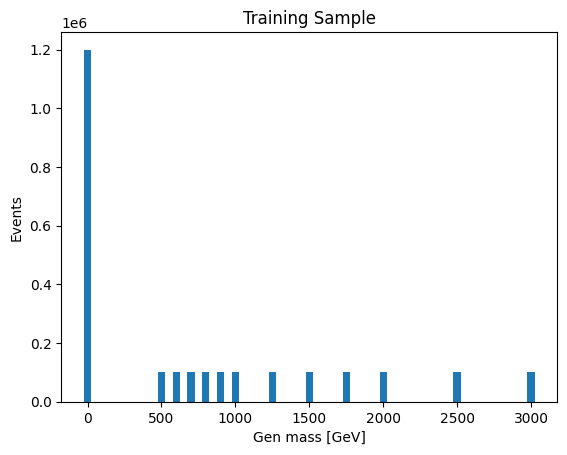

In [10]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((max(Masses) - min(Masses))/50) + 1,
             range = [min(Masses)-25, max(Masses)+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

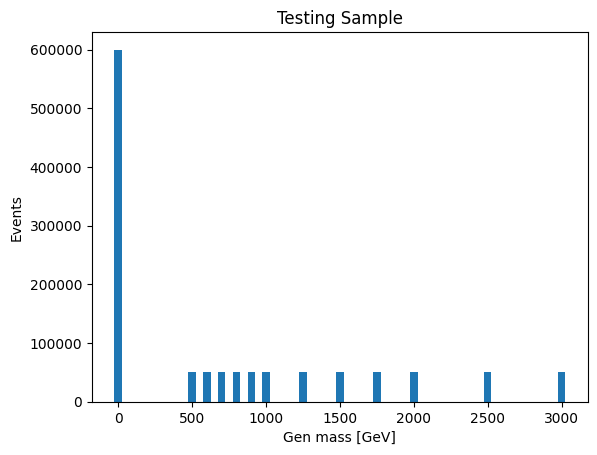

In [11]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((max(Masses) - min(Masses))/50) + 1,
             range = [min(Masses)-25, max(Masses)+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

/tmp/ipykernel_2484/1985655967.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


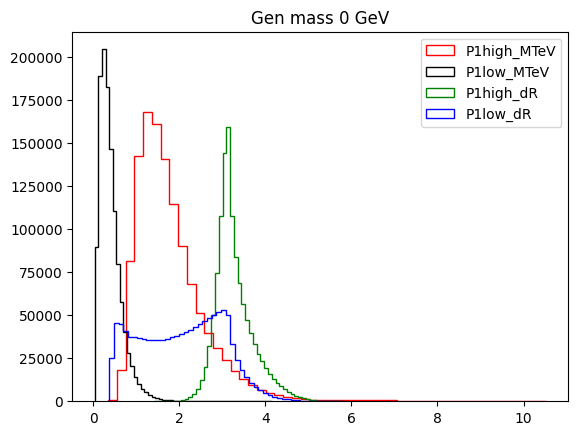

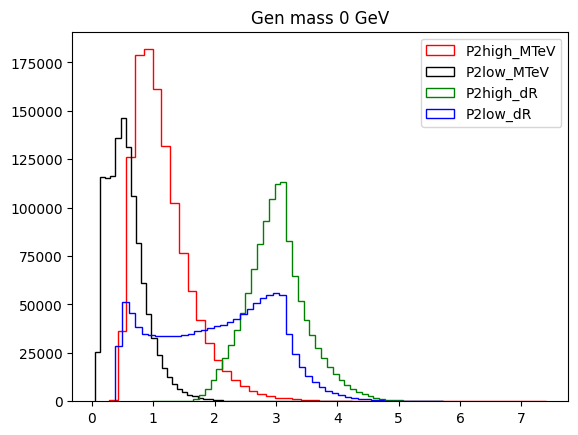

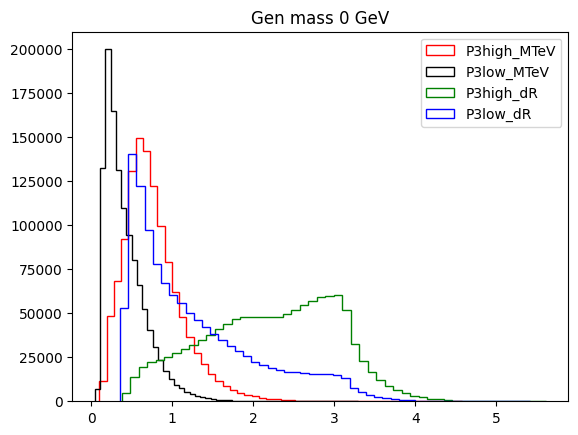

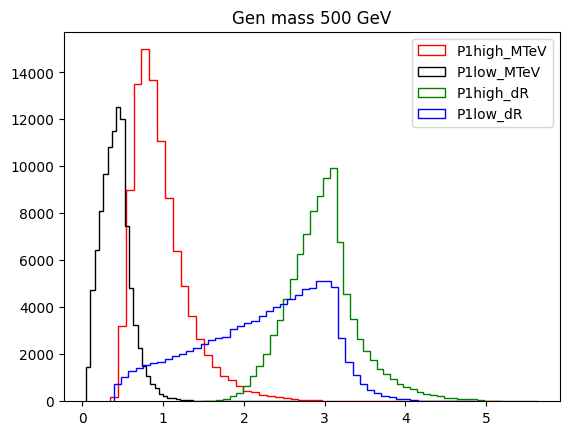

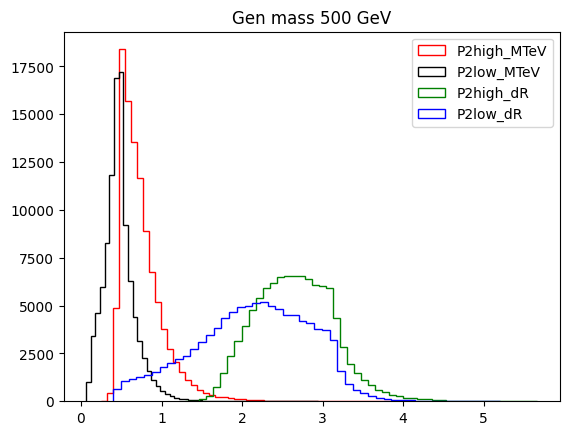

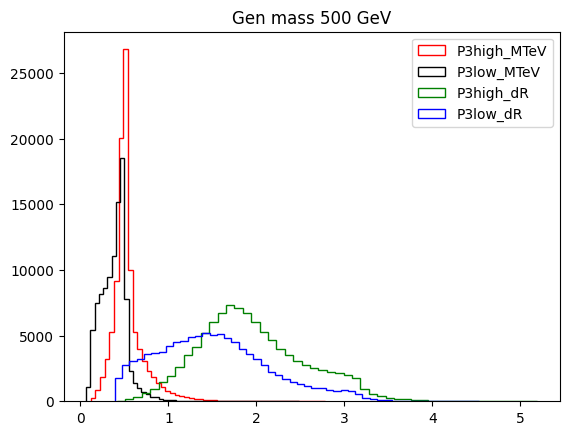

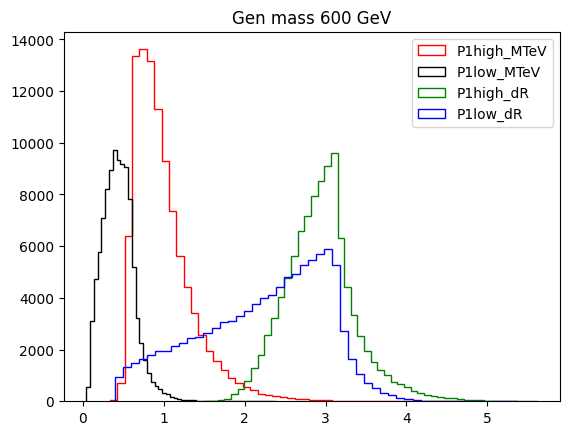

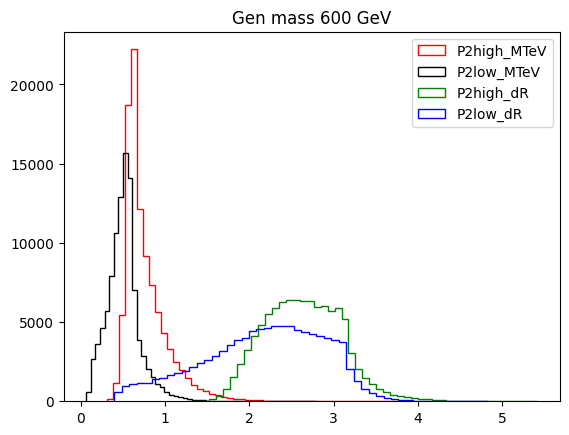

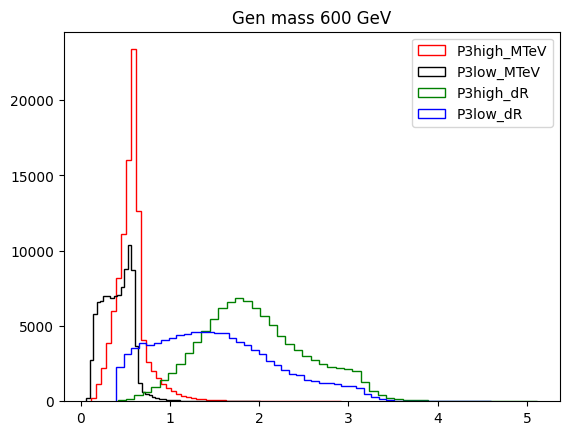

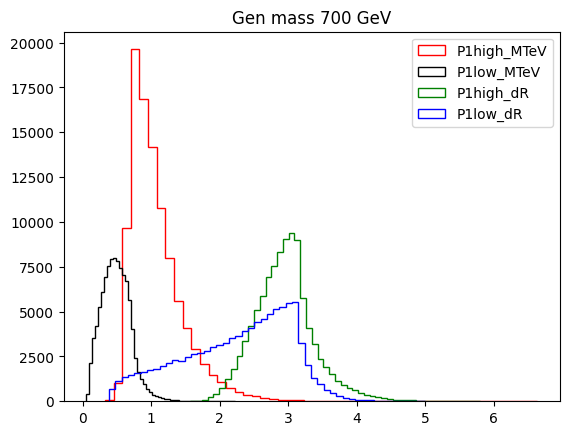

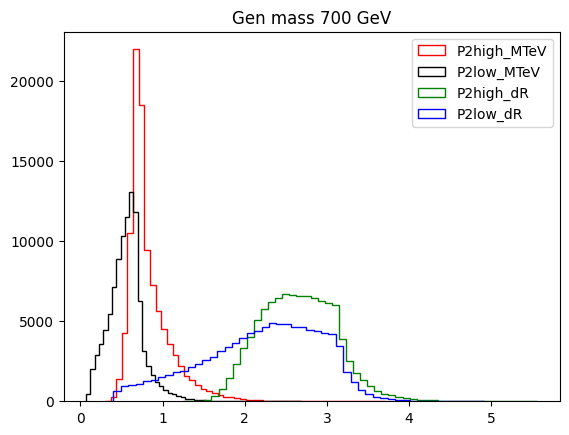

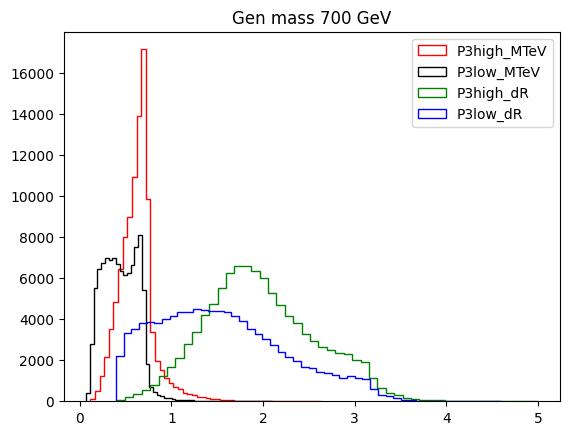

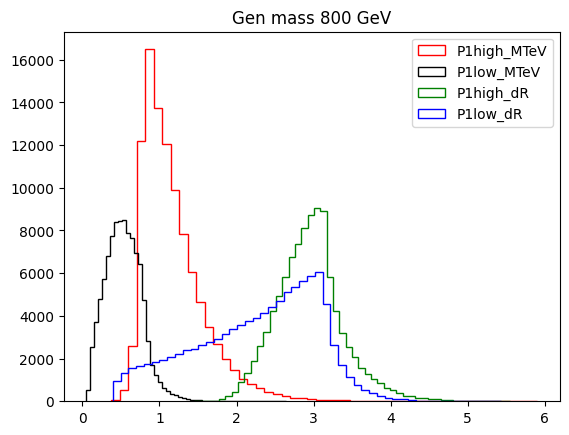

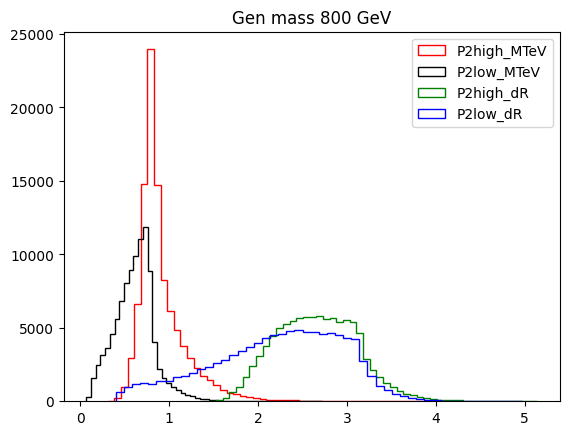

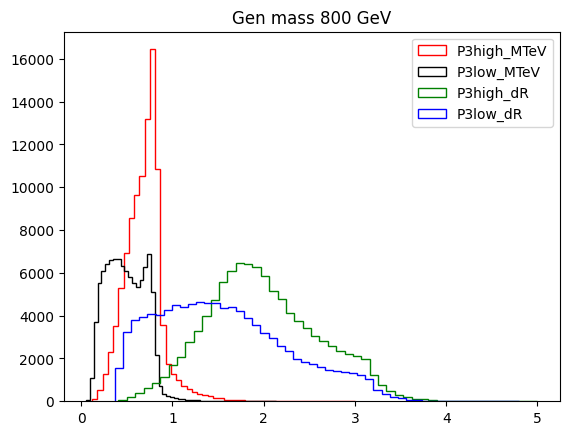

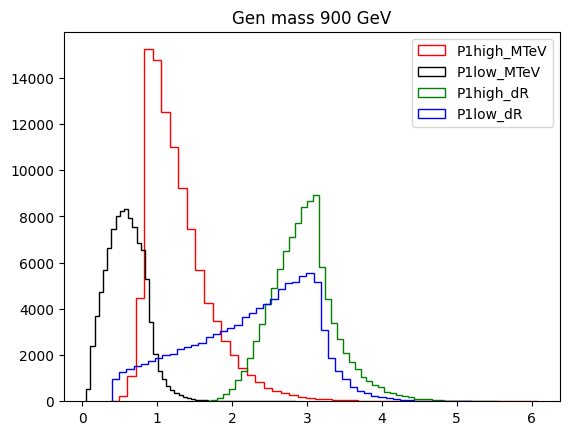

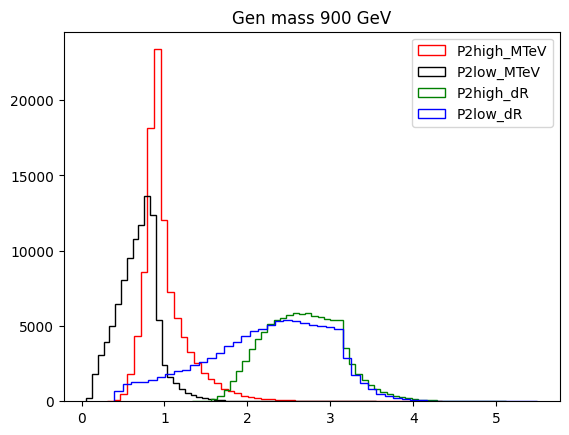

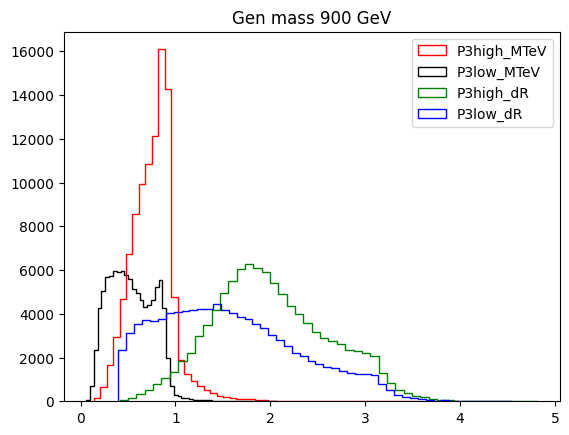

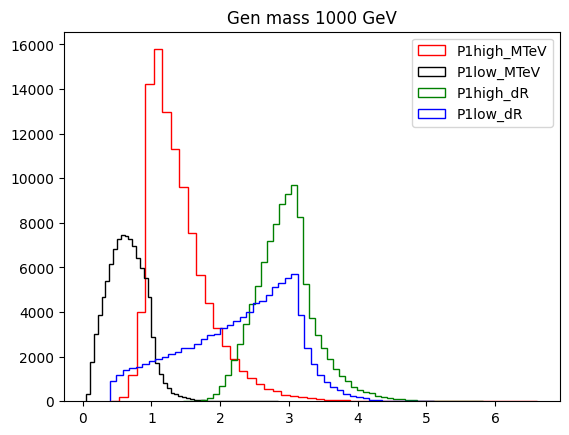

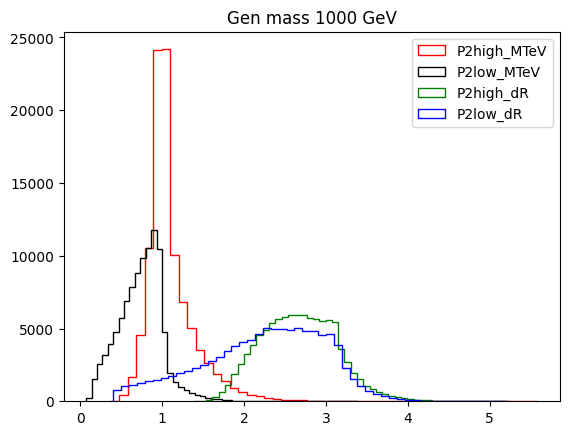

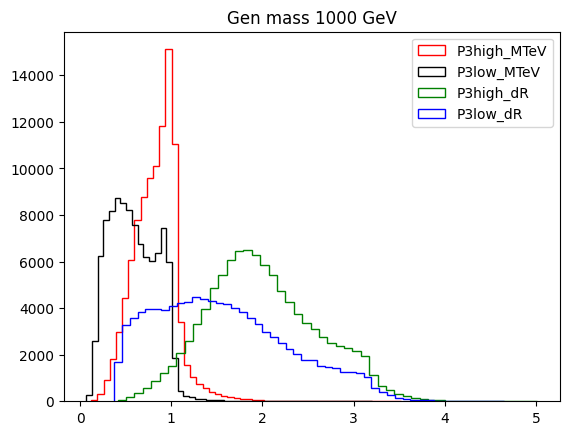

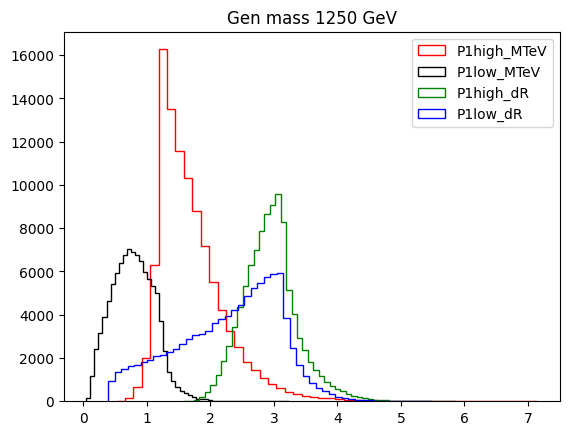

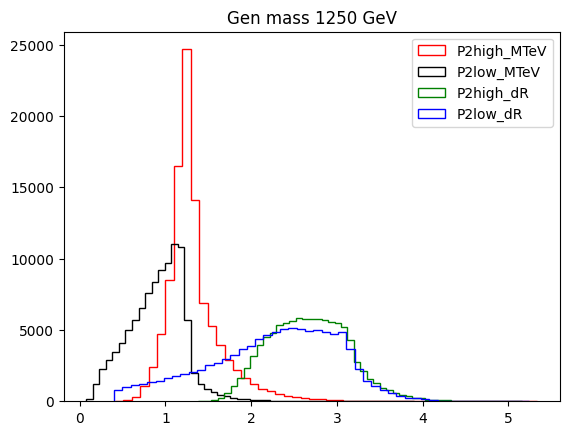

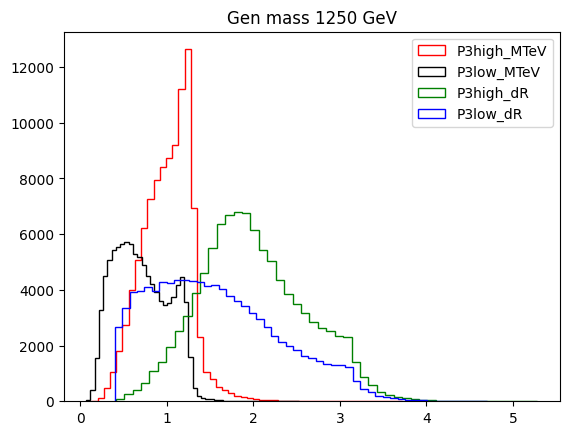

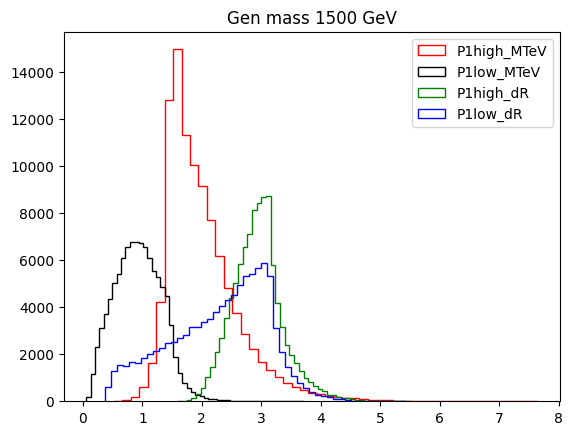

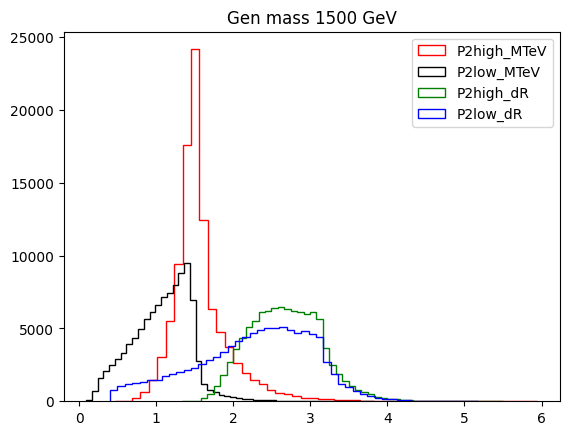

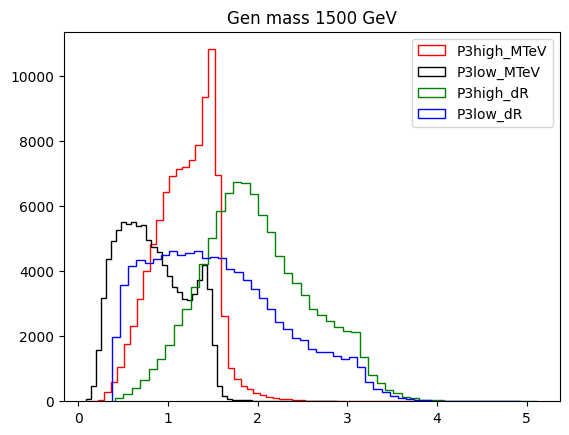

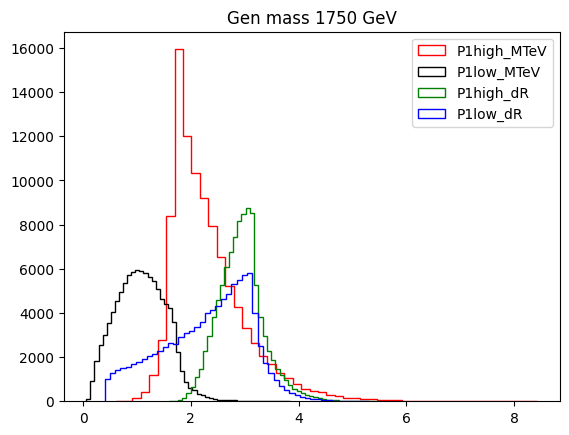

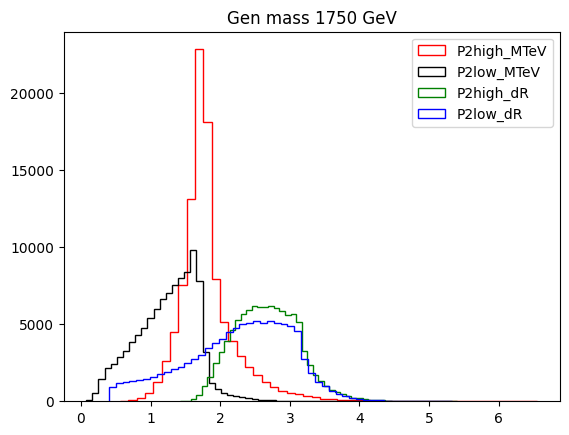

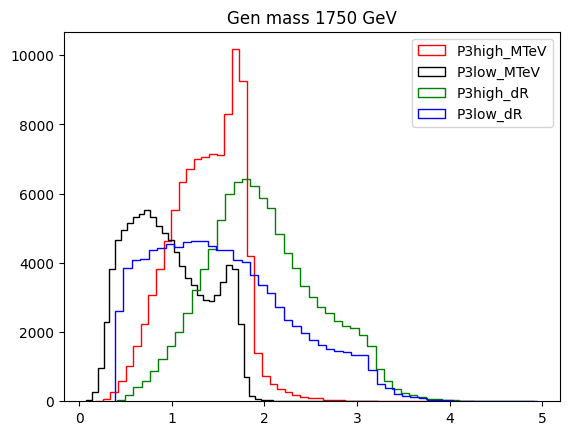

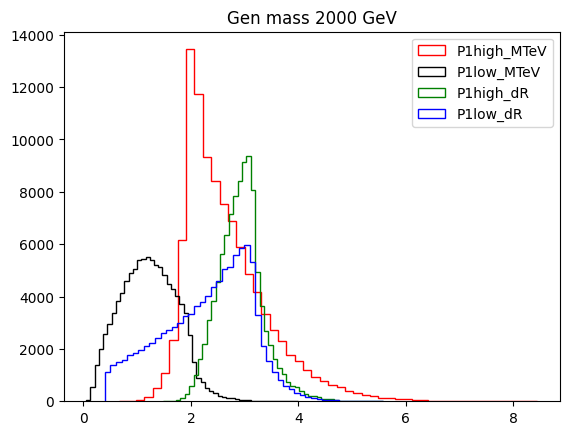

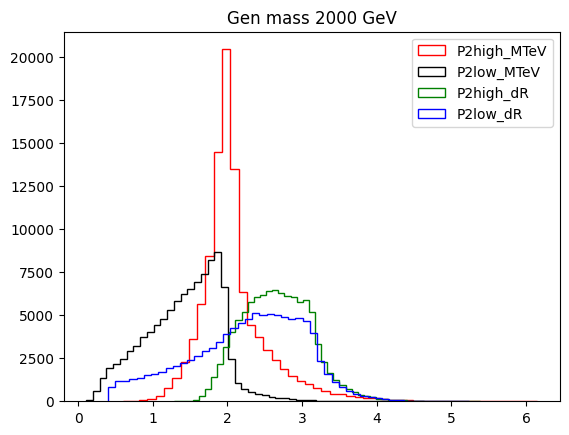

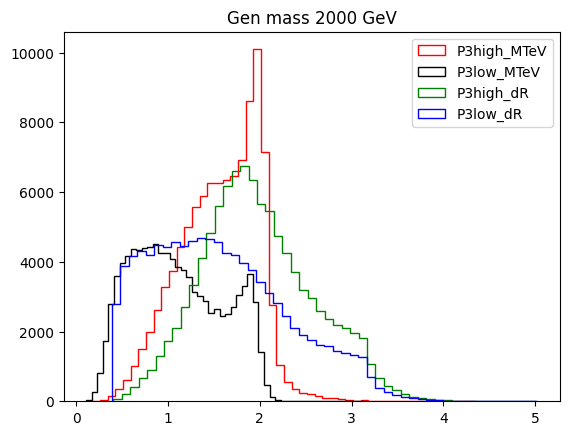

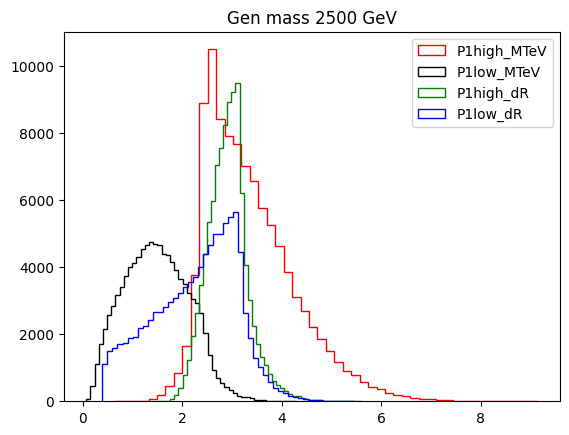

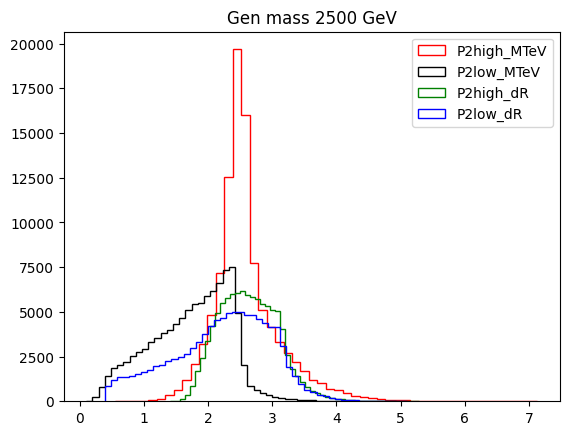

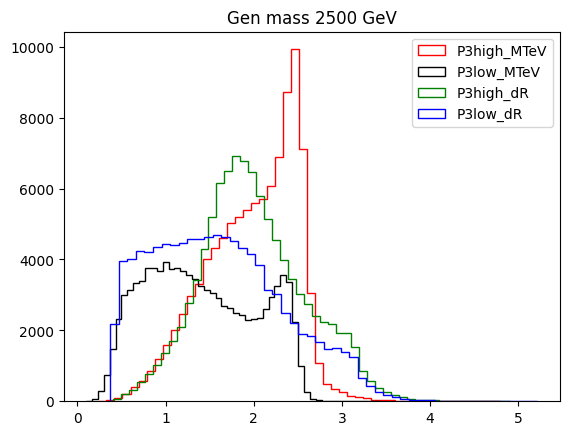

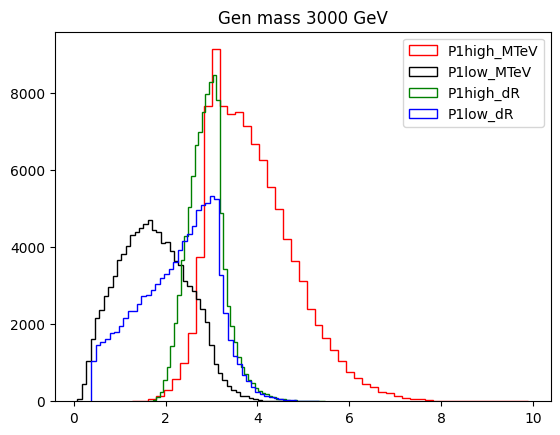

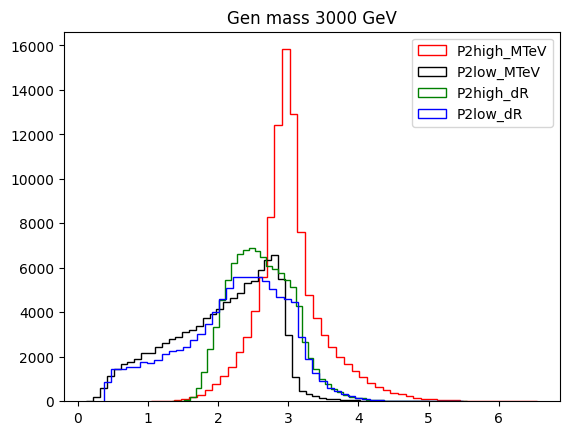

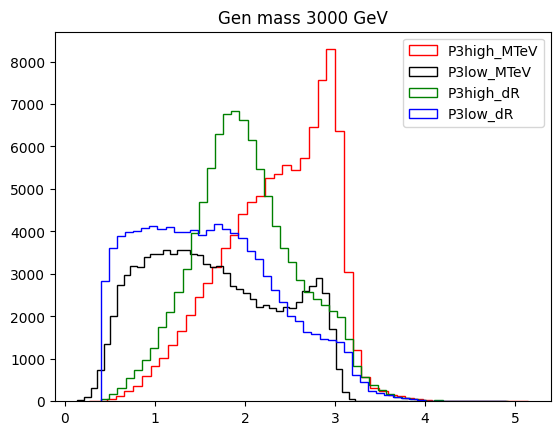

In [12]:
if SanityCheckPlots:
    for Mass in Masses:
        for Pair in ["P1", "P2", "P3"]:
            TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
            plt.figure()
            plt.hist(TrainingDF_temp[Pair + "high_MTeV"], bins = 50, histtype = "step", color = "r", label = Pair + "high_MTeV")
            plt.hist(TrainingDF_temp[Pair + "low_MTeV"], bins = 50, histtype = "step", color = "k", label = Pair + "low_MTeV")
            plt.hist(TrainingDF_temp[Pair + "high_dR"], bins = 50, histtype = "step", color = "g", label = Pair + "high_dR")
            plt.hist(TrainingDF_temp[Pair + "low_dR"], bins = 50, histtype = "step", color = "b", label = Pair + "low_dR")
            plt.legend()
            plt.title("Gen mass " + str(Mass) + " GeV")

In [13]:
InputList = ["fourjetmasstev", "P1high_MTeV", "P1low_MTeV", "P1high_dR", "P1low_dR",
             "fourjetmasstev", "P2high_MTeV", "P2low_MTeV", "P2high_dR", "P2low_dR",
             "fourjetmasstev", "P3high_MTeV", "P3low_MTeV", "P3high_dR", "P3low_dR",]


TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [14]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(2400000, 15)
(2400000,)
(1200000, 15)


In [15]:
NotebookName = "SigBG_CNN_more"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [16]:
def model_CNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [17]:
def model_CNN_more():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(32, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax', name="model_out")],
        name = "ModelCNNMore"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [18]:
#Model = model_CNN()
Model = model_CNN_more()

2023-12-09 10:59:04.160602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 10:59:05.353762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [19]:
Model.summary()

Model: "ModelCNNMore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 32)          224       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 16)          3088      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 model_out (Dense)           (None, 2)                 18        
                                                                 
Total params: 3,466
Trainable params: 3,466
Non-traina

In [20]:
import pydot
import graphviz
tf.keras.utils.plot_model(Model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 100, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/100


2023-12-09 10:59:08.183374: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


384/384 [==============================] - 5s 6ms/step - loss: 0.4085 - accuracy: 0.8146 - val_loss: 0.3632 - val_accuracy: 0.8396
Epoch 2/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3622 - accuracy: 0.8402 - val_loss: 0.3583 - val_accuracy: 0.8419
Epoch 3/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3587 - accuracy: 0.8417 - val_loss: 0.3562 - val_accuracy: 0.8427
Epoch 4/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3573 - accuracy: 0.8421 - val_loss: 0.3545 - val_accuracy: 0.8438
Epoch 5/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3563 - accuracy: 0.8426 - val_loss: 0.3556 - val_accuracy: 0.8432
Epoch 6/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3554 - accuracy: 0.8430 - val_loss: 0.3531 - val_accuracy: 0.8443
Epoch 7/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3548 - accuracy: 0.8431 - val_loss: 0.3528 - val_accuracy: 0.8445
Epoch 8/100

384/384 [==============================] - 2s 5ms/step - loss: 0.3461 - accuracy: 0.8472 - val_loss: 0.3447 - val_accuracy: 0.8479
Epoch 59/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3462 - accuracy: 0.8471 - val_loss: 0.3451 - val_accuracy: 0.8475
Epoch 60/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3460 - accuracy: 0.8472 - val_loss: 0.3448 - val_accuracy: 0.8478
Epoch 61/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3460 - accuracy: 0.8473 - val_loss: 0.3444 - val_accuracy: 0.8480
Epoch 62/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3458 - accuracy: 0.8472 - val_loss: 0.3443 - val_accuracy: 0.8481
Epoch 63/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3460 - accuracy: 0.8472 - val_loss: 0.3455 - val_accuracy: 0.8473
Epoch 64/100
384/384 [==============================] - 2s 5ms/step - loss: 0.3457 - accuracy: 0.8473 - val_loss: 0.3446 - val_accuracy: 0.8478
Epoch

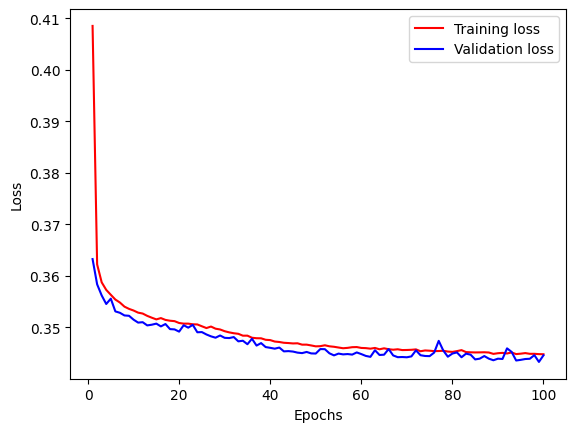

In [22]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [23]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

240/240 [==============================] - 1s 2ms/step


In [24]:
print(TestingOutputs.shape)
print(TestingOutputs[0]) #ML raw output is the probability of 2 sparse categories

(1200000, 2)
[0.9225695  0.07743053]


In [25]:
TestingDF["PredSigProb"] = TestingOutputs[:,1].tolist()
TestingDF

,Mass,evt_trig,fourjetmasstev,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,Truth,PredSigProb
0,0,1,4.464072,3.217578,0.825004,2.338068,0.713922,1.586149,0.712653,3.444736,3.094801,3.257106,2.568927,2.825521,0.808671,0,0.077431
1,0,1,3.996752,2.694024,0.764736,2.295783,0.854021,1.433233,0.317492,4.611473,1.877971,3.733321,1.999995,3.296683,0.968936,0,0.231858
2,0,1,3.026084,2.448377,0.354898,1.190166,0.728888,1.021031,0.279483,3.351977,2.844524,2.940603,2.433256,3.148620,0.952745,0,0.009934
3,0,1,2.434140,1.204221,1.156724,1.165381,1.101052,0.714974,0.288992,2.927671,3.142084,3.041204,3.267227,1.409741,0.486652,0,0.799836
4,0,1,3.192649,2.815268,0.170924,1.022089,0.284866,0.904395,0.564098,3.169546,1.732016,2.413405,0.853620,3.116542,1.419114,0,0.012767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,3000,1,6.142254,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,3.557276,3.214979,2.495388,3.063509,2.823131,2.938442,1,0.985054
1199996,3000,1,5.129152,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,3.294043,2.397300,2.841346,3.037939,1.969007,0.621246,1,0.975262
1199997,3000,1,6.280539,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,4.409254,3.134380,3.414219,3.425090,1.548936,1.288221,1,0.552256
1199998,3000,1,6.048077,3.156473,2.037133,2.874936,2.729543,2.142006,1.502817,2.828993,3.045544,2.500509,3.260420,1.784493,1.213136,1,0.998599


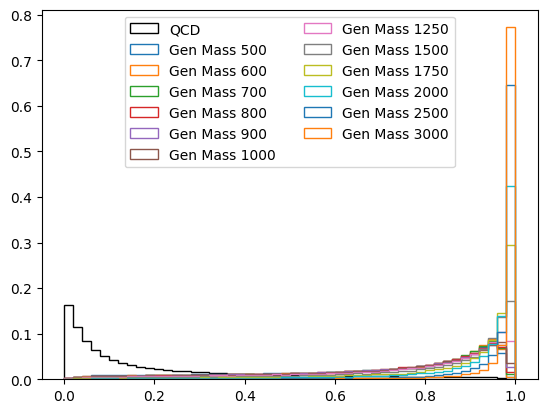

In [26]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    if Mass == 0:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "QCD", color="k")
    else:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper center")

plt.savefig(ResultsDir + "Pred_Signal_Prob.png")

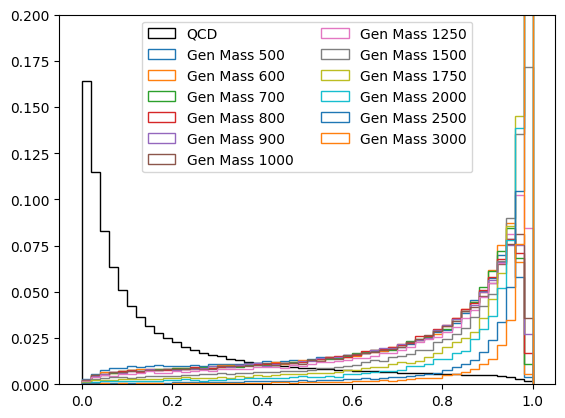

In [27]:
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]

    if Mass == 0:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "QCD", color="k")
    else:
        plt.hist(TestingDF_temp["PredSigProb"], bins = 50, range = [0, 1], histtype = "step",
                 weights = np.array([1.0/len(TestingDF_temp.index)] * len(TestingDF_temp.index)),
                 label = "Gen Mass " + str(Mass))
    plt.legend(ncol=2, loc="upper center")
    plt.ylim(0, 0.2)
    
plt.savefig(ResultsDir + "Pred_Signal_Prob_Zoom.png")

Thresholds ['0.94', '0.78', '0.63']
Efficiencies ['0.39', '0.66', '0.78']


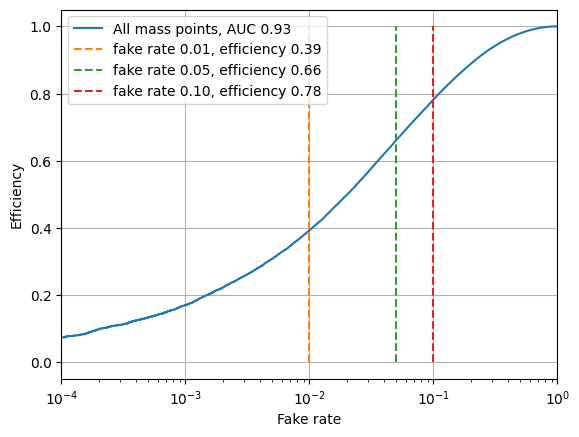

In [28]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(TestingDF["Truth"].to_numpy(),
                                 TestingDF["PredSigProb"].to_numpy())
roc_auc = auc(fpr, tpr)

#plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
plt.plot(fpr, tpr, label = "All mass points, AUC %.2f" % roc_auc)
plt.xlabel("Fake rate")
plt.ylabel("Efficiency")
plt.xscale("log")
plt.xlim(0.0001, 1)
plt.grid()

FakeRates = [0.01, 0.05, 0.1]
Thresholds = []
Efficiencies = []
for FakeRate in FakeRates:
    Index = (np.abs(fpr - FakeRate)).argmin()
    Thresholds.append(thresholds[Index])
    Efficiencies.append(tpr[Index])
    
    plt.plot([FakeRate, FakeRate], [0, 1], linestyle="--",
             label = "fake rate %.2f, efficiency %.2f" % (FakeRate, tpr[Index]))
    
plt.legend()
plt.savefig(ResultsDir + "ROC_all_logX.png")

#print(fpr)
#print(thresholds)
print("Thresholds", ["%.2f" % i for i in Thresholds])
print("Efficiencies", ["%.2f" % i for i in Efficiencies])

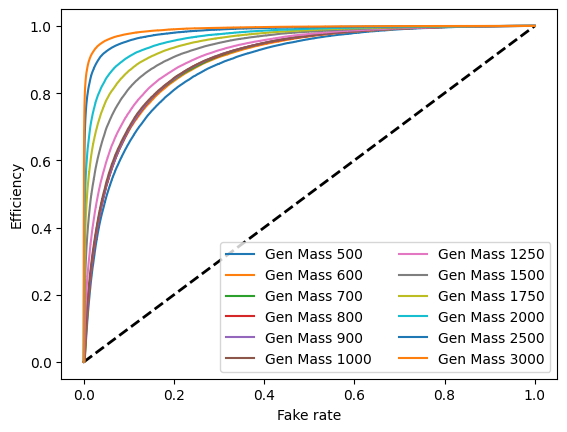

In [29]:
TestingDF_QCD = TestingDF.loc[TestingDF["Mass"] == 0]

for Mass in Masses:
    if Mass == 0:
        plt.plot([0, 1], [0, 1], color="k", lw=2, linestyle="--")
    else:
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        TestingDF_temp = pd.concat([TestingDF_temp, TestingDF_QCD], ignore_index=True)
        fpr, tpr, thresholds = roc_curve(TestingDF_temp["Truth"].to_numpy(),
                                         TestingDF_temp["PredSigProb"].to_numpy())

        plt.plot(fpr, tpr, label = "Gen Mass " + str(Mass))
        plt.xlabel("Fake rate")
        plt.ylabel("Efficiency")
        plt.legend(ncol=2, loc="lower right")
        
plt.savefig(ResultsDir + "ROC.png")

In [30]:
TestingDF["PredTight"] = (TestingDF["PredSigProb"] > Thresholds[0]).astype(int)
TestingDF["PredMedium"] = (TestingDF["PredSigProb"] > Thresholds[1]).astype(int)
TestingDF["PredLoose"] = (TestingDF["PredSigProb"] > Thresholds[2]).astype(int)

AccPredTight = []
AccPredMedium = []
AccPredLoose = []

for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    
    TestingDF_PredTight = TestingDF_temp.loc[TestingDF_temp["PredTight"]==TestingDF_temp["Truth"]]
    TestingDF_PredMedium = TestingDF_temp.loc[TestingDF_temp["PredMedium"]==TestingDF_temp["Truth"]]
    TestingDF_PredLoose = TestingDF_temp.loc[TestingDF_temp["PredLoose"]==TestingDF_temp["Truth"]]
    
    AccPredTight.append(float(len(TestingDF_PredTight.index))/len(TestingDF_temp.index))
    AccPredMedium.append(float(len(TestingDF_PredMedium.index))/len(TestingDF_temp.index))
    AccPredLoose.append(float(len(TestingDF_PredLoose.index))/len(TestingDF_temp.index))

In [31]:
AccPredTightAvg = "Avg %.2f" % float(sum(AccPredTight)/len(AccPredTight))
AccPredMediumAvg = "Avg %.2f" % float(sum(AccPredMedium)/len(AccPredMedium))
AccPredLooseAvg = "Avg %.2f" % float(sum(AccPredLoose)/len(AccPredLoose))

print(["%.2f" % i for i in AccPredTight], AccPredTightAvg)
print(["%.2f" % i for i in AccPredMedium], AccPredMediumAvg)
print(["%.2f" % i for i in AccPredLoose], AccPredLooseAvg)

['0.99', '0.16', '0.18', '0.18', '0.18', '0.20', '0.21', '0.28', '0.41', '0.54', '0.65', '0.81', '0.89'] Avg 0.44
['0.95', '0.49', '0.52', '0.53', '0.52', '0.53', '0.54', '0.60', '0.70', '0.78', '0.84', '0.92', '0.96'] Avg 0.68
['0.90', '0.65', '0.69', '0.69', '0.69', '0.69', '0.70', '0.74', '0.81', '0.87', '0.91', '0.96', '0.98'] Avg 0.79


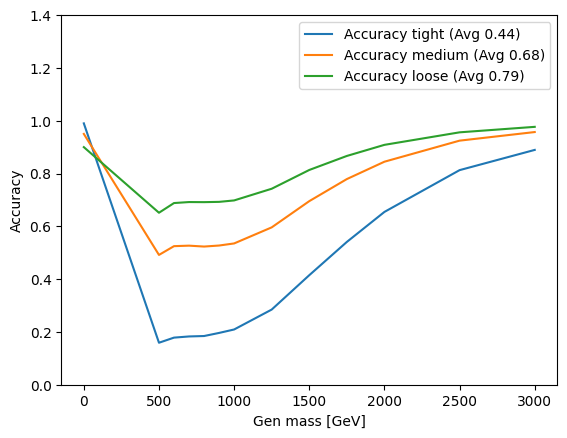

In [32]:
plt.plot(Masses, AccPredTight, label = "Accuracy tight (" + AccPredTightAvg + ")")
plt.plot(Masses, AccPredMedium, label = "Accuracy medium (" + AccPredMediumAvg + ")")
plt.plot(Masses, AccPredLoose, label = "Accuracy loose (" + AccPredLooseAvg + ")")

plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")